In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Colab Notebooks/input"

In [5]:
!kaggle datasets download -d arindamxd/eyes-open-closed-dataset

Dataset URL: https://www.kaggle.com/datasets/arindamxd/eyes-open-closed-dataset
License(s): MIT
 80% 58.0M/72.4M [00:00<00:00, 67.7MB/s]
100% 72.4M/72.4M [00:01<00:00, 75.1MB/s]


In [7]:
import zipfile
zip_path = '/content/eyes-open-closed-dataset.zip'
new_folder_path = '/content/datasets/open'
Path(new_folder_path).mkdir(parents=True, exist_ok=True)
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(new_folder_path)


In [8]:
import os

def count_png_files(base_dir):
    counts = {}
    total_count = 0
    # Sınıf dizinlerini listele
    class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

    # Her sınıf dizinindeki .png dosyalarını say
    for class_dir in class_dirs:
        class_path = os.path.join(base_dir, class_dir)
        png_files = [f for f in os.listdir(class_path) if f.endswith('.png')]
        count = len(png_files)
        counts[class_dir] = count
        total_count += count

    return counts, total_count

# Ana veri dizinleri
train_dir = '/content/datasets/open/dataset/train'
test_dir = '/content/datasets/open/dataset/train'

# Train dizinindeki .png dosyalarını say
train_counts, train_total = count_png_files(train_dir)
print("Train directory .png file counts:")
for class_dir, count in train_counts.items():
    print(f"Class '{class_dir}' contains {count} .png files.")
print(f"Total .png files in train directory: {train_total}")

# Test dizinindeki .png dosyalarını say
test_counts, test_total = count_png_files(test_dir)
print("\nTest directory .png file counts:")
for class_dir, count in test_counts.items():
    print(f"Class '{class_dir}' contains {count} .png files.")
print(f"Total .png files in test directory: {test_total}")

# Toplam dosya sayılarını en sonda göster
print(f"\nTotal .png files in train directory: {train_total}")
print(f"Total .png files in test directory: {test_total}")


Train directory .png file counts:
Class 'open' contains 1640 .png files.
Class 'closed' contains 1760 .png files.
Total .png files in train directory: 3400

Test directory .png file counts:
Class 'open' contains 1640 .png files.
Class 'closed' contains 1760 .png files.
Total .png files in test directory: 3400

Total .png files in train directory: 3400
Total .png files in test directory: 3400


In [ ]:
################################## Verida Valid Yaratma işlemi ##################################

In [10]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Ana veri dizini
base_dir = '/content/datasets/open/dataset/train'

# Sınıf dizinlerini listele
class_dirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]
print("Classes found:", class_dirs)

# Hedef dizin
output_base_dir = '/content/datasets/open/dataset/valid'
os.makedirs(output_base_dir, exist_ok=True)

# Belirli bir yüzde veya sayıda dosya seç
subset_ratio = 0.18  # %18'ini almak için

for class_dir in class_dirs:
    # Sınıf dizinindeki dosyaları listele
    image_files = [f for f in os.listdir(os.path.join(base_dir, class_dir)) if f.endswith('.png')]

    # Belirli bir yüzde veya belirli sayıda dosya seç
    subset_size = int(len(image_files) * subset_ratio)
    image_subset, _ = train_test_split(image_files, train_size=subset_ratio, random_state=42)

    # Hedef sınıf dizinini oluştur
    output_class_dir = os.path.join(output_base_dir, class_dir)
    os.makedirs(output_class_dir, exist_ok=True)

    # Seçilen dosyaları kopyalayın ve ana veri dizininden silin
    for img_file in image_subset:
        src_path = os.path.join(base_dir, class_dir, img_file)
        dst_path = os.path.join(output_class_dir, img_file)
        shutil.copy(src_path, dst_path)
        os.remove(src_path)

    print(f"{len(image_subset)} images from class '{class_dir}' have been copied to '{output_class_dir}' and removed from the original directory.")


Classes found: ['open', 'closed']
295 images from class 'open' have been copied to '/content/datasets/open/dataset/valid/open' and removed from the original directory.
316 images from class 'closed' have been copied to '/content/datasets/open/dataset/valid/closed' and removed from the original directory.


In [11]:
# Veri yolunu ayarla
train_dir = '/content/datasets/open/dataset/train'
validation_dir = '//content/datasets/open/dataset/valid'
test_dir = '/content/datasets/open/dataset/test'

# ImageDataGenerator ile veri artırma
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=True)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Veriyi yükle
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(128, 128), batch_size=32, class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size=(128, 128), batch_size=32, class_mode='binary')
test_generator = test_datagen.flow_from_directory(test_dir, target_size=(128, 128), batch_size=32, class_mode='binary', shuffle=False)
import datetime as dt
import os


Found 4023 images belonging to 2 classes.
Found 611 images belonging to 2 classes.
Found 818 images belonging to 2 classes.


In [13]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import datetime
import os

# CNN modelini oluştur
model = Sequential()

# 1. Konvolüsyon katmanı
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# 2. Konvolüsyon katmanı
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# 3. Konvolüsyon katmanı
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

# Flatten katmanı
model.add(Flatten())

# Tam bağlantılı katman
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Çıkış katmanı (2 sınıf için)
model.add(Dense(1, activation='sigmoid'))

# Modeli derleme
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Model özetini yazdır
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                        

In [14]:

# TensorBoard callback'i için log dizinini belirleyin
log_dir = os.path.join("logs", "fit", dt.datetime.now().strftime("%Y%m%d-%H%M%S")) # Use dt.datetime instead of just datetime

# ... (rest of your code remains unchanged)

# TensorBoard callback'ini oluşturun
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Modeli eğitin ve TensorBoard callback'ini callbacks listesine ekleyin
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tensorboard_callback
    ]
)

# Eğitim ve doğrulama kaybını ve doğruluğunu görselleştirme
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))



Epoch 1/10
126/126 [==============================] - 183s 1s/step - loss: 0.5060 - accuracy: 0.8332 - val_loss: 3.9600 - val_accuracy: 0.5172
Epoch 2/10
126/126 [==============================] - 177s 1s/step - loss: 0.3411 - accuracy: 0.8822 - val_loss: 4.3056 - val_accuracy: 0.5172
Epoch 3/10
126/126 [==============================] - 184s 1s/step - loss: 0.2569 - accuracy: 0.9110 - val_loss: 2.8244 - val_accuracy: 0.5172
Epoch 4/10
126/126 [==============================] - 183s 1s/step - loss: 0.1991 - accuracy: 0.9351 - val_loss: 1.4569 - val_accuracy: 0.6367
Epoch 5/10
126/126 [==============================] - 174s 1s/step - loss: 0.1674 - accuracy: 0.9478 - val_loss: 0.1612 - val_accuracy: 0.9231
Epoch 6/10
126/126 [==============================] - 176s 1s/step - loss: 0.1486 - accuracy: 0.9505 - val_loss: 0.0877 - val_accuracy: 0.9755
Epoch 7/10
126/126 [==============================] - 191s 2s/step - loss: 0.1455 - accuracy: 0.9498 - val_loss: 0.0932 - val_accuracy: 0.9558

In [15]:
# Modeli test et ve tahminleri al
pred = model.predict(test_generator)
pred = (pred > 0.5).astype(int).flatten()

# Gerçek etiketleri al
y_test = test_generator.classes

# Doğruluk hesapla
accuracy = accuracy_score(y_test, pred)
print(f'Test Doğruluğu: {accuracy * 100:.2f}%')

26/26 [==============================] - 9s 339ms/step
Test Doğruluğu: 99.02%


1/1 [==============================] - 0s 322ms/step


<ipython-input-17-a5d6ea4fc149>:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_label = list(test_generator.class_indices.keys())[int(pred[0] > 0.5)]


1/1 [==============================] - 1s 628ms/step


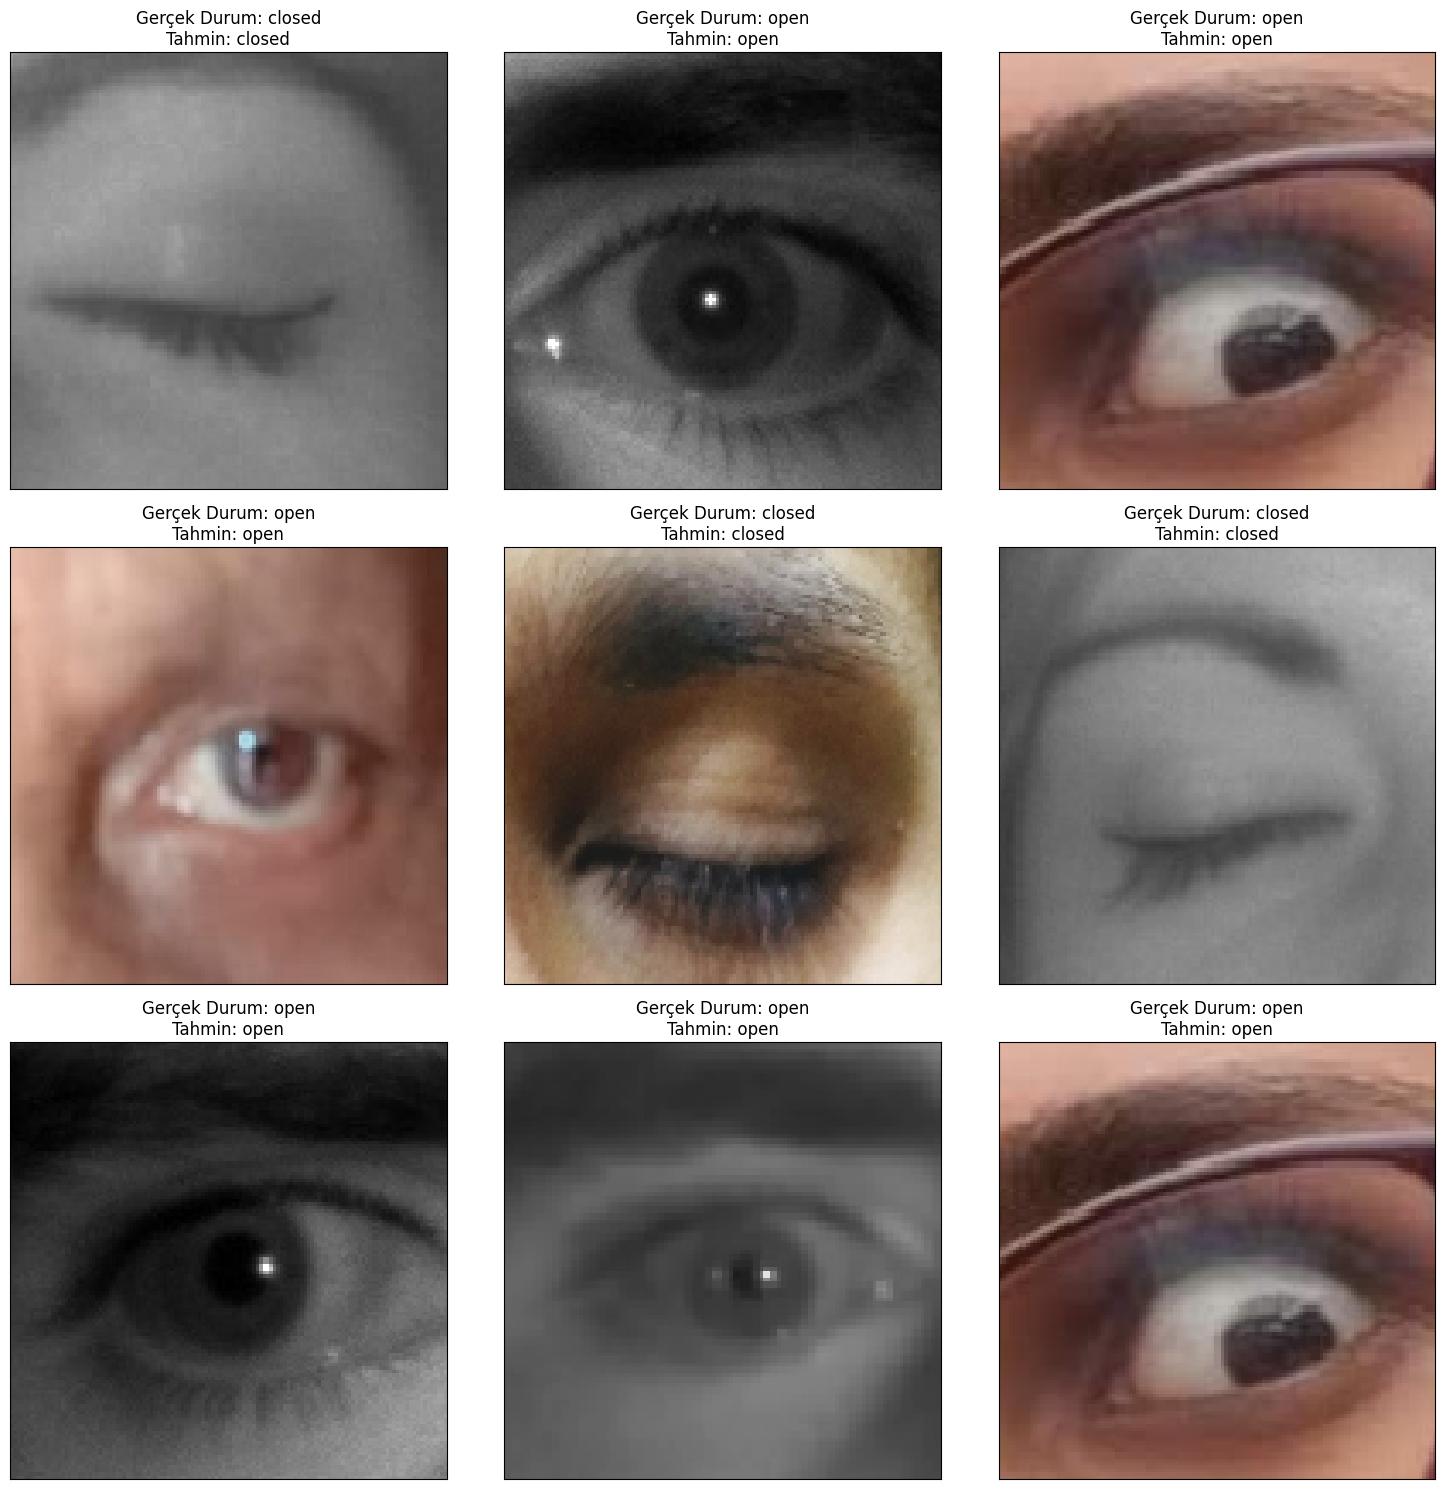

In [17]:

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    index = np.random.randint(len(test_generator))
    img, label_index = test_generator[index]
    true_label = list(test_generator.class_indices.keys())[int(label_index[0])]

    pred = model.predict(img)
    predicted_label = list(test_generator.class_indices.keys())[int(pred[0] > 0.5)]

    ax.imshow(img[0])
    ax.set_title(f"Gerçek Durum: {true_label}\nTahmin: {predicted_label}")

plt.tight_layout()
plt.show()